<h1 style="text-align: center; color:#90edaa"> EDA - Codeforces Multilabel Classification - Par Kikia Dia </h1>
<!-- <h5 style="text-align: center"> Auteur :  Kikia DIA - AI Engineer</h5> -->
<!-- <h4>Exploratory Data Analysis - EDA</h4> -->


<p>
L’objectif de cette <strong>Exploratory Data Analysis (EDA)</strong> est de :
</p>

<ul>
  <li>comprendre la structure générale du dataset,</li>
  <li>analyser la distribution des tags,</li>
  <li> Faire du text preprocessing</li>
  <li>identifier features exploitables pour la tâche de <strong>classification multi-labels</strong>.</li>
</ul>




## Sommaire

1. [Chargement des données](#1.-Chargement-des-données)
2. [Sélection des tags cibles](#2-sélection-des-tags-cibles)
3. [Construction de la description textuelle](#3-construction-de-la-description-textuelle)
4. [One-hot-encoding avec MultiLabelBinarizer](#4-One-hot-encoding-avec-MultiLabelBinarizer)
5. [Analyse textuelle brute](#5-analyse-textuelle-brute)
   - [Taille des descriptions](#taille-des-descriptions)
   - [WordCloud par tag](#wordcloud-par-tag)
6. [Nettoyage de texte](#6.-Nettoyage-de-texte)
7. [Analyse des labels](#7-analyse-des-labels)
   - [Distribution des tags](#distribution-des-tags)
   - [Co-occurrence des tags](#co-occurrence-des-tags)
8. [Analyse du code source](#8-analyse-du-code-source)
   - [Feature engineering](#feature-engineering)
   - [Corrélation features code ↔ tags](#corrélation-features-code--tags)
<!-- 8. [Conclusion de l’EDA](#conclusion-de-leda) -->


## 1. Chargement des données

In [2]:
from google.colab import drive
import zipfile
import os

# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Chemins (à adapter si besoin)
ZIP_PATH = "/content/drive/MyDrive/code_classification_dataset.zip"
DATASET_DIR = "/content/data"

# Créer le dossier de destination s'il n'existe pas
os.makedirs(DATASET_DIR, exist_ok=True)

# Extraire le zip
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATASET_DIR)

print("Fichiers extraits :", len(os.listdir("/content/data/code_classification_dataset")))


Fichiers extraits : 4982


In [4]:
import json
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TEXT_FIELDS = [
    "prob_desc_description",
    "prob_desc_input_spec",
    "prob_desc_output_spec",
    "prob_desc_notes",
    "source_code",
    "tags"
]

def load_dataset(dataset_dir):
    records = []
    json_files = glob(os.path.join(dataset_dir, "*.json"))
    print(f"{len(json_files)} fichiers JSON trouvés")

    for path in json_files:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Créer un nouveau dictionnaire pour chaque fichier JSON
        record = {}
        for field in TEXT_FIELDS:
            record[field] = data.get(field, "") or ""

        # S'assurer que 'tags' est une liste
        if not isinstance(record["tags"], list):
            record["tags"] = []

        records.append(record)

    df = pd.DataFrame(records)

    # Nettoyage supplémentaire
    for field in TEXT_FIELDS:
        df[field] = df[field].fillna("")

    # Forcer l'ordre des colonnes
    df = df[TEXT_FIELDS]

    return df


In [5]:
df = load_dataset("/content/data/code_classification_dataset")

4982 fichiers JSON trouvés


In [6]:
df.head(2)

prob_desc_description  \
0  There are n sharks who grow flowers for Wet Sh...   
1  This is a hard version of the problem. The act...   

                                prob_desc_input_spec  \
0  The first line of the input contains two space...   
1  The first line of the input contains one integ...   

                               prob_desc_output_spec  \
0  Print a single real number — the expected numb...   
1  In the first line print one integer $$$res$$$ ...   

                                     prob_desc_notes  \
0  NoteA prime number is a positive integer numbe...   
1                                                      

                                         source_code  \
0  f = lambda: list(map(int, input().split()))\nn...   
1  n = int(input())\ns = input()\ncol = [1] * n\n...   

                                                tags  
0  [combinatorics, number theory, probabilities, ...  
1                              [data structures, dp]

In [7]:
df.describe()

prob_desc_description  \
count                                                4982   
unique                                               4982   
top     Bear Limak has n colored balls, arranged in on...   
freq                                                    1   

       prob_desc_input_spec prob_desc_output_spec prob_desc_notes  \
count                  4982                  4982            4982   
unique                 4928                  4822            3597   
top                                                                 
freq                     33                    85            1350   

                                              source_code              tags  
count                                                4982              4982  
unique                                               4982              1907  
top     N = int(5e3+3)\nn = int(input())\nres = [0] * ...  [implementation]  
freq                                                    1               273

## 2. Sélection des tags cibles

In [8]:
TARGET_TAGS = [
    'math', 'graphs', 'strings', 'number theory',
    'trees', 'geometry', 'games', 'probabilities'
]

def filter_target_tags(tags):
    return [t for t in tags if t in TARGET_TAGS]


In [9]:
df["tags"] = df["tags"].apply(filter_target_tags)

df = df[df["tags"].map(len) > 0]

In [10]:
df.describe()

prob_desc_description  \
count                                                2678   
unique                                               2678   
top     The determinant of a matrix 2 × 2 is defined a...   
freq                                                    1   

       prob_desc_input_spec prob_desc_output_spec prob_desc_notes  \
count                  2678                  2678            2678   
unique                 2649                  2588            1981   
top                                                                 
freq                     25                    58             678   

                                              source_code    tags  
count                                                2678    2678  
unique                                               2678      77  
top     from decimal import *\nimport sys\ngetcontext(...  [math]  
freq                                                    1     928

## 3. Construction de la description textuelle

In [11]:
# Colonnes à concaténer
cols_to_concat = [
    "prob_desc_description",
    "prob_desc_input_spec",
    "prob_desc_output_spec",
    "prob_desc_notes"
]

# Créer une nouvelle colonne 'description' en concaténant les colonnes avec un espace
df['description'] = df[cols_to_concat].agg(' '.join, axis=1)


In [12]:
df["description"].iloc[0]

"There are n sharks who grow flowers for Wet Shark. They are all sitting around the table, such that sharks i and i\u2009+\u20091 are neighbours for all i from 1 to n\u2009-\u20091. Sharks n and 1 are neighbours too.Each shark will grow some number of flowers si. For i-th shark value si is random integer equiprobably chosen in range from li to ri. Wet Shark has it's favourite prime number p, and he really likes it! If for any pair of neighbouring sharks i and j the product si·sj is divisible by p, then Wet Shark becomes happy and gives 1000 dollars to each of these sharks.At the end of the day sharks sum all the money Wet Shark granted to them. Find the expectation of this value. The first line of the input contains two space-separated integers n and p (3\u2009≤\u2009n\u2009≤\u2009100\u2009000,\u20092\u2009≤\u2009p\u2009≤\u2009109)\xa0— the number of sharks and Wet Shark's favourite prime number. It is guaranteed that p is prime. The i-th of the following n lines contains information a

In [13]:
df.head(1)

prob_desc_description  \
0  There are n sharks who grow flowers for Wet Sh...   

                                prob_desc_input_spec  \
0  The first line of the input contains two space...   

                               prob_desc_output_spec  \
0  Print a single real number — the expected numb...   

                                     prob_desc_notes  \
0  NoteA prime number is a positive integer numbe...   

                                         source_code  \
0  f = lambda: list(map(int, input().split()))\nn...   

                                   tags  \
0  [number theory, probabilities, math]   

                                         description  
0  There are n sharks who grow flowers for Wet Sh...

## 4. One-hot-encoding avec MultiLabelBinarizer

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["tags"])


In [15]:
df = pd.concat(
    [
        df[["description", "source_code"]].reset_index(drop=True),
        pd.DataFrame(
            y,
            columns=mlb.classes_
        )
    ],
    axis=1
)

In [16]:
df.describe()

games     geometry       graphs         math  number theory  \
count  2678.000000  2678.000000  2678.000000  2678.000000    2678.000000   
mean      0.039208     0.061987     0.202390     0.525765       0.130695   
std       0.194127     0.241176     0.401856     0.499429       0.337129   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.000000     0.000000     0.000000     0.000000       0.000000   
50%       0.000000     0.000000     0.000000     1.000000       0.000000   
75%       0.000000     0.000000     0.000000     1.000000       0.000000   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       probabilities      strings        trees  
count    2678.000000  2678.000000  2678.000000  
mean        0.034354     0.157580     0.120986  
std         0.182171     0.364415     0.326172  
min         0.000000     0.000000     0.000000  
25%         0.000000     0.000000     0.000000  
50%         0.000000     0.000000     0.000000  
75%         0.000000     0.000000     0.000000  
max         1.000000     1.000000     1.000000

## 5. Analyse textuelle brute

### Taille des descriptions

In [17]:
df["description"].iloc[0]

"There are n sharks who grow flowers for Wet Shark. They are all sitting around the table, such that sharks i and i\u2009+\u20091 are neighbours for all i from 1 to n\u2009-\u20091. Sharks n and 1 are neighbours too.Each shark will grow some number of flowers si. For i-th shark value si is random integer equiprobably chosen in range from li to ri. Wet Shark has it's favourite prime number p, and he really likes it! If for any pair of neighbouring sharks i and j the product si·sj is divisible by p, then Wet Shark becomes happy and gives 1000 dollars to each of these sharks.At the end of the day sharks sum all the money Wet Shark granted to them. Find the expectation of this value. The first line of the input contains two space-separated integers n and p (3\u2009≤\u2009n\u2009≤\u2009100\u2009000,\u20092\u2009≤\u2009p\u2009≤\u2009109)\xa0— the number of sharks and Wet Shark's favourite prime number. It is guaranteed that p is prime. The i-th of the following n lines contains information a

In [18]:
len(df["description"].iloc[0])

2516

In [19]:
from tqdm.auto import tqdm

def get_vocab(docs : pd.Series) -> set:

    vocab = set()

    for doc in tqdm(docs):
        vocab.update(doc.split())

    return vocab

In [20]:
vocab = get_vocab(df['description'])
print(f"The vocabulary contains {len(vocab)} unique words.")

  0%|          | 0/2678 [00:00<?, ?it/s]

The vocabulary contains 47674 unique words.


In [21]:
df['description_len'] = df['description'].apply(lambda x: len(x.split()))

<Axes: xlabel='description_len', ylabel='Count'>

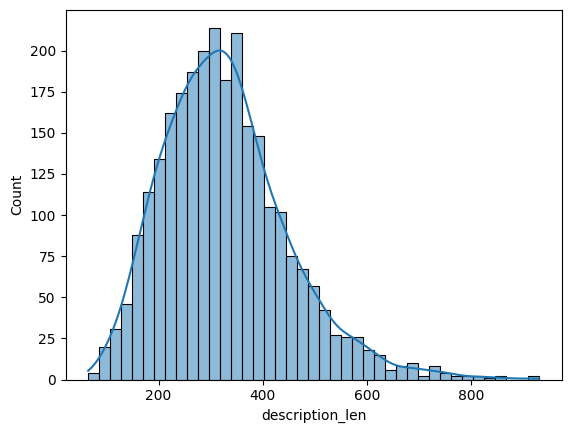

In [22]:
sns.histplot(df['description_len'], kde=True)

### WordCloud par tag

In [47]:
from wordcloud import WordCloud

def plot_wordcloud(
    df : pd.DataFrame,
    label : str,
    ax : plt.Axes = None
) -> plt.Axes:

    df = df[df[label] == 1] # Filter rows with the label
    df = df[FEATURES] # Keep only the features columns

    text = df.apply(lambda x: " ".join(x), axis=1).str.cat(sep=" ") # Concatenate the features columns

    wc = WordCloud(width=800,  background_color="black", colormap="viridis",height=400).generate(text)

    if ax is None:
        _, ax = plt.subplots()

    ax.imshow(wc)
    ax.axis("off")
    ax.set_title(f"Wordcloud for label: {label}", fontsize=30)

    return ax

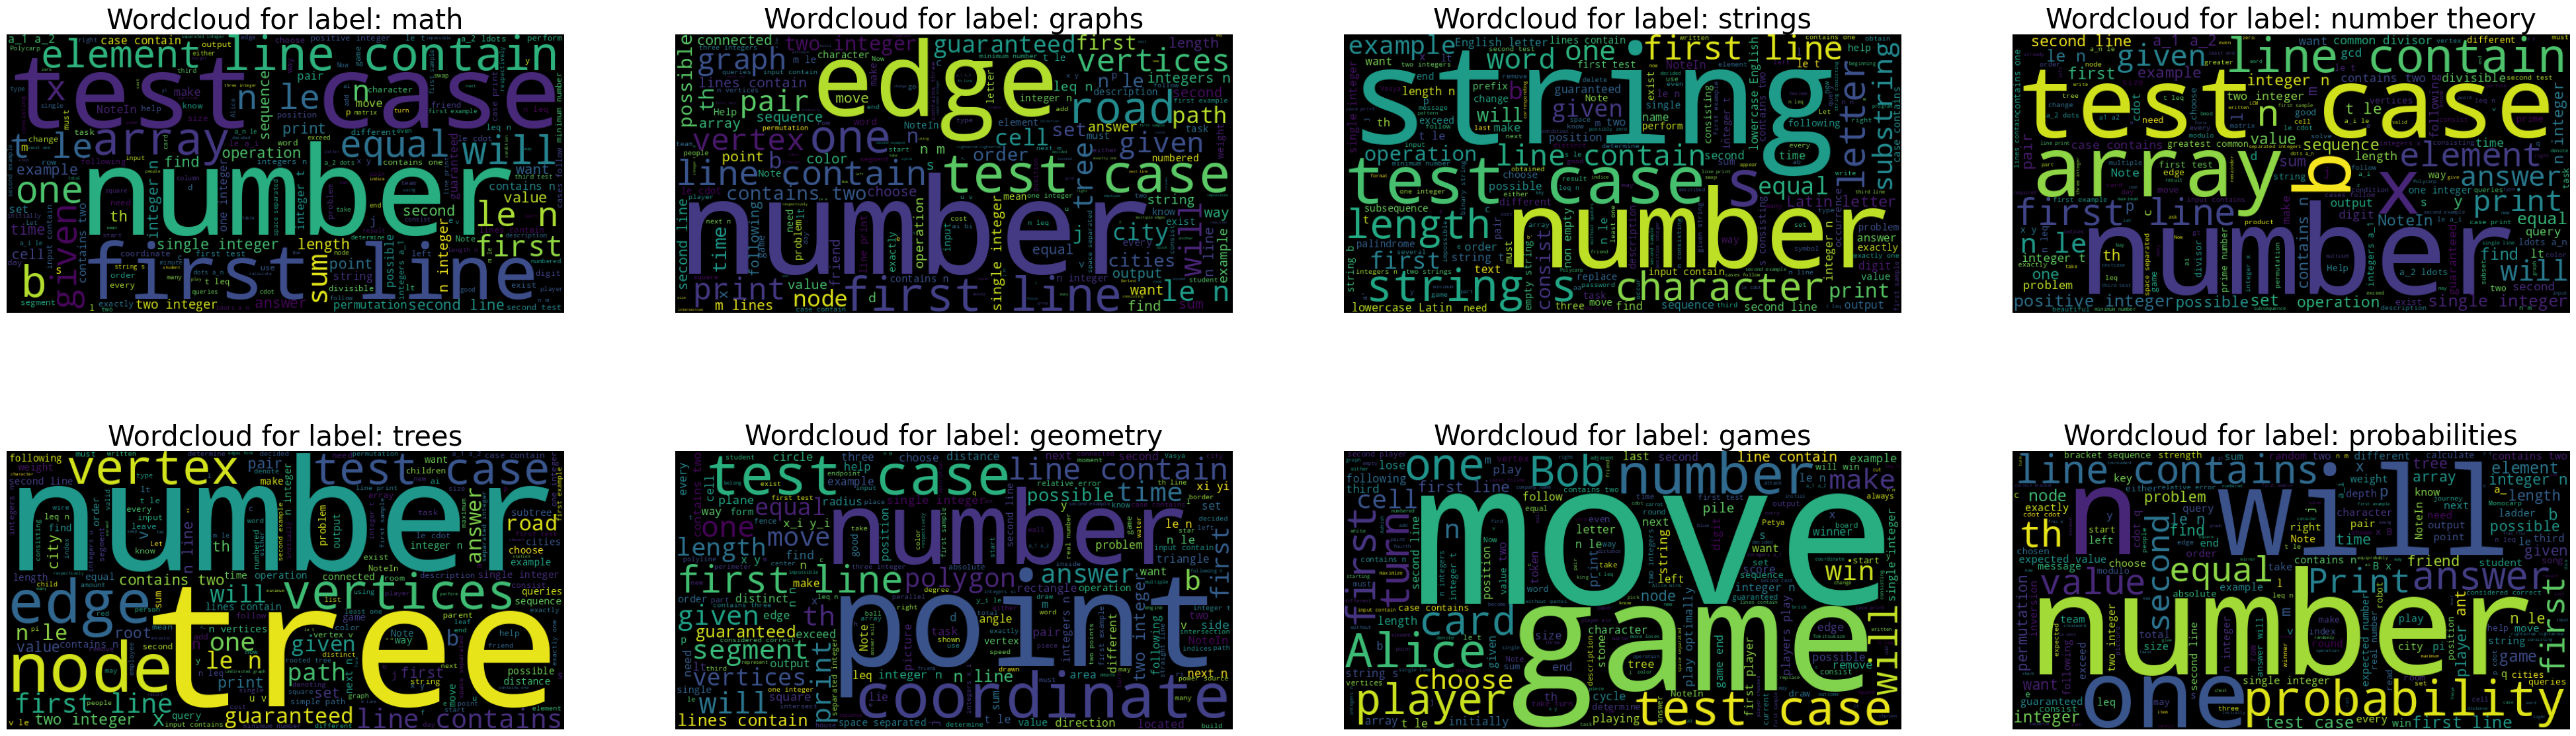

In [48]:
FEATURES = ["description"]
fig, axes = plt.subplots(2, 4, figsize=(50, 15))

i = 0

for row in axes:
    for cell in row:
        label = TARGET_TAGS[i]
        plot_wordcloud(df, label, cell)
        i += 1

## 6. Nettoyage de texte

In [25]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00


In [55]:
import re
import nltk
import contractions

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

class DataProcessor:

    def __init__(self):
        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        self.stopwords.update({"test", "case", "x", "n", "line", "contain","input","first","le","contains","one","number","second","th","integer"})

        # self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer("english")

    def __call__(self, text: str) -> str:

        text = text.lower() # Lowercase
        text = text.replace('-', ' ') # Replace hyphens with spaces
        text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # Remove special characters
        text = re.sub(r"\s+", " ", text) # Remove extra whitespaces
        text = re.sub(r"\d+", " ", text) # Remove digits
        text = contractions.fix(text) # Expand contractions, for example don't -> do not

        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stopwords]
        # tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        tokens = [self.stemmer.stem(word) for word in tokens]

        return " ".join(tokens)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [27]:
from tqdm.auto import tqdm
tqdm.pandas()

In [50]:
processor = DataProcessor()
df['description_clean'] = df['description'].progress_apply(processor)

  0%|          | 0/2678 [00:00<?, ?it/s]

In [56]:
df["description_clean"].iloc[0]

'shark grow flower wet shark sit around tabl shark neighbour shark neighbour shark grow flower si shark valu si random equiprob chosen rang li ri wet shark favourit prime p realli like pair neighbour shark j product si sj divis p wet shark becom happi give dollar shark end day shark sum money wet shark grant find expect valu two space separ integ p p shark wet shark favourit prime guarante p prime follow line inform shark two space separ integ li ri li ri rang flower shark produc rememb si chosen equiprob among integ li ri inclus print singl real expect dollar shark receiv total answer consid correct absolut rel error exceed name let assum answer answer juri b checker program consid answer correct notea prime posit divis consid prime consid sampl shark grow flower shark grow flower third eight case quantiti flower shark grow note pair dollar award shark therefor shark award dollar total dollar product divis therefor shark receiv dollar shark receiv total total total total total total t

In [57]:
len(df["description_clean"].iloc[0])

1056

In [58]:
vocab = get_vocab(df['description_clean'])
print(f"The vocabulary contains {len(vocab)} unique words.")

  0%|          | 0/2678 [00:00<?, ?it/s]

The vocabulary contains 7552 unique words.


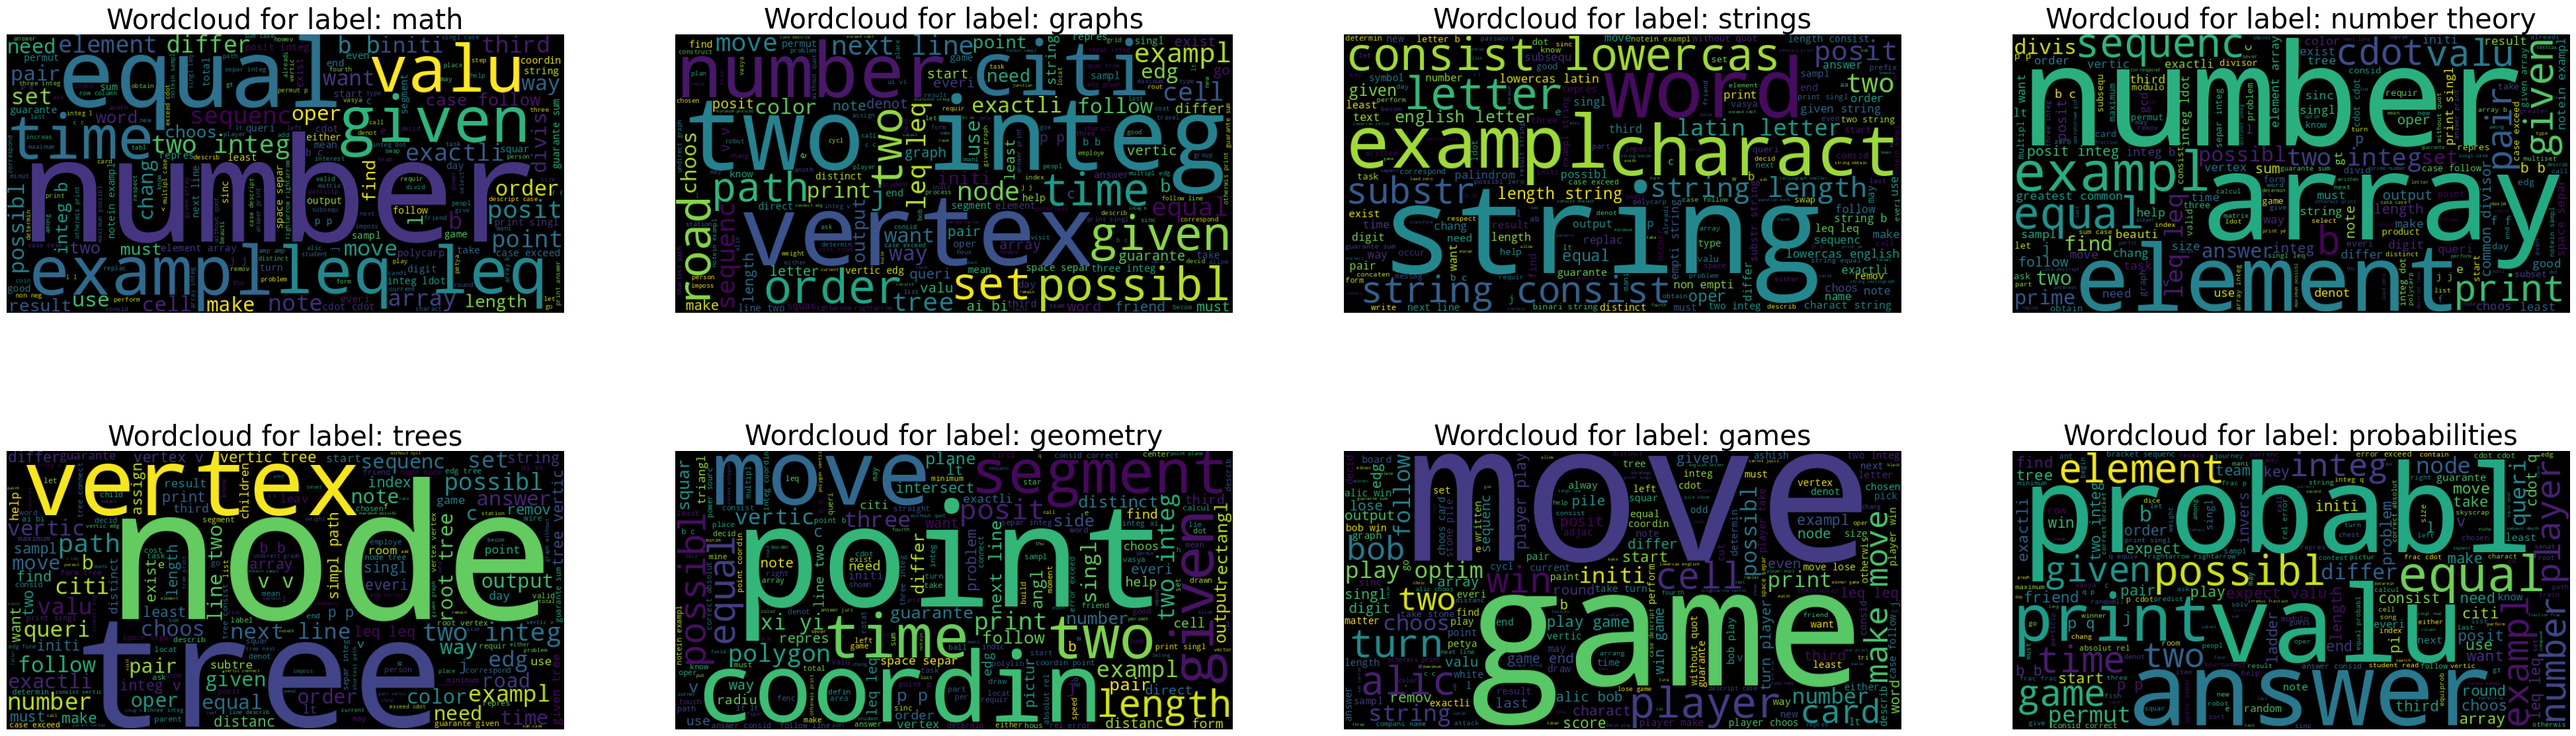

In [59]:
FEATURES = ["description_clean"]
fig, axes = plt.subplots(2, 4, figsize=(50, 15))

i = 0

for row in axes:
    for cell in row:
        label = TARGET_TAGS[i]
        plot_wordcloud(df, label, cell)
        i += 1

## 7. Analyse des labels

### Distribution des tags

/tmp/ipython-input-2695311997.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


Text(0.5, 0, 'Labels')

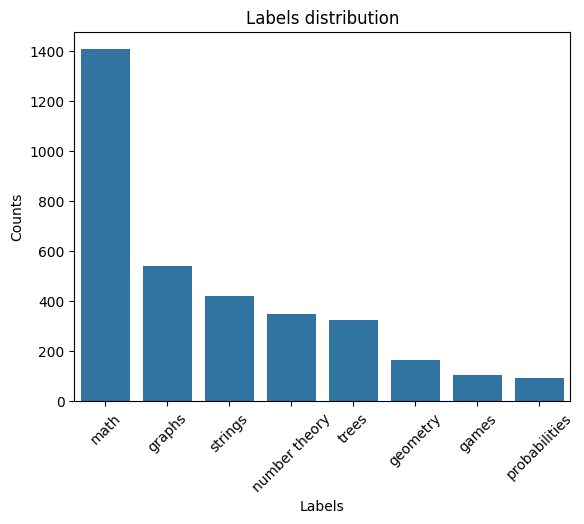

In [33]:
labels_counts = df[TARGET_TAGS].sum(axis=0)
labels, counts = labels_counts.index, labels_counts.values
ax = sns.barplot(x=labels, y=counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Labels distribution")
ax.set_ylabel("Counts")
ax.set_xlabel("Labels")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        2678 non-null   object
 1   source_code        2678 non-null   object
 2   games              2678 non-null   int64 
 3   geometry           2678 non-null   int64 
 4   graphs             2678 non-null   int64 
 5   math               2678 non-null   int64 
 6   number theory      2678 non-null   int64 
 7   probabilities      2678 non-null   int64 
 8   strings            2678 non-null   int64 
 9   trees              2678 non-null   int64 
 10  description_len    2678 non-null   int64 
 11  description_clean  2678 non-null   object
dtypes: int64(9), object(3)
memory usage: 251.2+ KB


### Co-occurrence des tags

<Axes: >

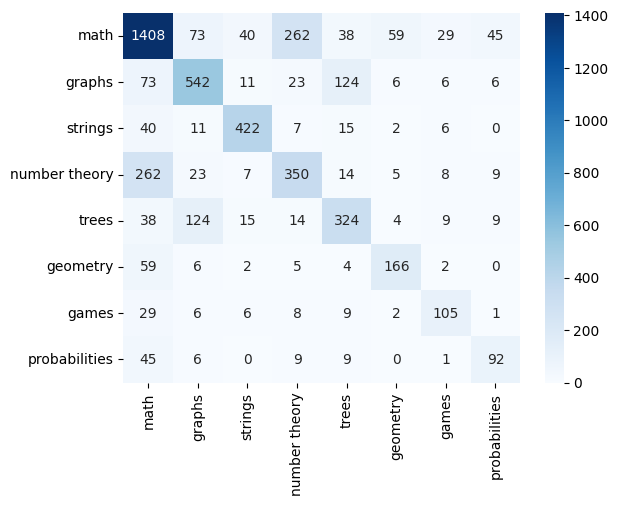

In [35]:
X = df[TARGET_TAGS].values
X = X.T @ X
sns.heatmap(X, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

<Axes: >

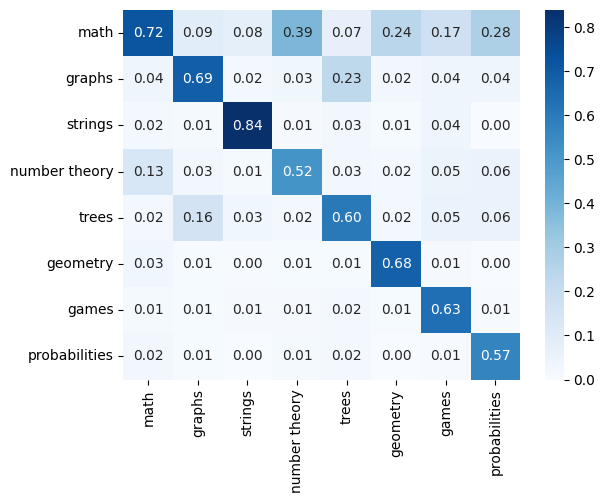

In [36]:
X = X / X.sum(axis=1)
sns.heatmap(X, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

## 8. Analyse du code source

### Feature engineering



In [37]:
# def extract_code_features(code):
#     """
#     Extraire des features pertinentes pour prédire les tags algorithmique.
#     """
#     features = {}

#     # -----------------------------
#     # 1️⃣ Structures mathématiques
#     # -----------------------------
#     features['has_mod'] = int('%' in code)                    # modulo
#     features['has_pow'] = int('**' in code or 'pow(' in code) # exponentiation
#     features['has_factorial'] = int('fact' in code)           # factorielle
#     features['has_comb'] = int('comb' in code)                # combinaisons
#     features['has_math_import'] = int('import math' in code)

#     # -----------------------------
#     # Graphes / parcours
#     # -----------------------------
#     features['has_dfs'] = int('dfs' in code.lower())          # DFS
#     features['has_bfs'] = int('bfs' in code.lower())          # BFS
#     features['has_edges'] = int('edges' in code.lower())
#     features['has_adj'] = int('adj' in code.lower())          # adjacency
#     features['has_graph_list'] = int('graph' in code.lower())

#     # -----------------------------
#     # Récursion / structures arborescentes
#     # -----------------------------
#     features['has_recursion'] = int('def' in code and code.count('def') > 1)
#     features['has_tree'] = int('tree' in code.lower())

#     # -----------------------------
#     # Chaînes et manipulation de strings
#     # -----------------------------
#     features['has_string'] = int('str(' in code or '"' in code or "'" in code)
#     # features['has_split'] = int('.split(' in code)
#     features['has_join'] = int('.join(' in code)

#     # -----------------------------
#     # Jeux / probabilités
#     # -----------------------------
#     features['has_random'] = int('random' in code)           # tirage aléatoire
#     features['has_probability'] = int('prob' in code.lower() or 'chance' in code.lower())

#     # -----------------------------
#     # Boucles / itérations
#     # -----------------------------
#     # features['has_for'] = int('for ' in code)
#     features['has_while'] = int('while ' in code)
#     # features['has_nested_loops'] = int(code.count('for ') + code.count('while ') > 1)

#     # -----------------------------
#     # Listes / tableaux
#     # -----------------------------
#     # features['has_list'] = int('[' in code and ']' in code)
#     features['has_append'] = int('.append(' in code)

#     return list(features.values())


In [62]:
import re

def extract_code_features(code: str):
    code_l = code.lower()
    features = {}

    # =====================================================
    # MATH / NUMBER THEORY
    # =====================================================
    features["has_mod"] = int("%" in code)
    features["has_pow"] = int("**" in code or "pow(" in code)
    features["has_gcd"] = int("gcd" in code_l)
    features["has_lcm"] = int("lcm" in code_l)
    features["has_prime"] = int("prime" in code_l)
    features["has_factorial"] = int("fact" in code_l)
    features["has_math_import"] = int("import math" in code_l)
    features["has_bit_ops"] = int(any(op in code for op in ["<<", ">>", "&", "|", "^"]))

    # =====================================================
    # GRAPHS
    # =====================================================
    features["has_dfs"] = int("dfs" in code_l)
    features["has_bfs"] = int("bfs" in code_l)
    features["has_adj_list"] = int("adj" in code_l or "neighbors" in code_l)
    features["has_edges"] = int("edges" in code_l)
    features["has_queue"] = int("deque" in code_l or "queue" in code_l)
    features["has_stack"] = int("stack" in code_l)
    features["has_visited"] = int("visited" in code_l)

    # =====================================================
    # TREES
    # =====================================================
    features["has_tree"] = int("tree" in code_l)
    features["has_node"] = int("node" in code_l)
    features["has_left_right"] = int("left" in code_l and "right" in code_l)
    features["has_recursion"] = int(code.count("def") > 1)
    features["has_depth"] = int("depth" in code_l or "height" in code_l)

    # =====================================================
    # STRINGS
    # =====================================================
    features["has_string_literal"] = int(bool(re.search(r"['\"]", code)))
    features["has_split"] = int(".split(" in code)
    features["has_join"] = int(".join(" in code)
    features["has_replace"] = int(".replace(" in code)
    features["has_substring"] = int("substr" in code_l or "substring" in code_l)
    features["has_ord_chr"] = int("ord(" in code or "chr(" in code)

    # =====================================================
    # PROBABILITIES
    # =====================================================
    features["has_probability"] = int("prob" in code_l or "chance" in code_l)
    features["has_fraction"] = int("fraction" in code_l)
    features["has_float_div"] = int("/" in code and "//" not in code)
    features["has_expectation"] = int("expect" in code_l)

    # =====================================================
    # GAMES
    # =====================================================
    features["has_random"] = int("random" in code_l)
    features["has_turn"] = int("turn" in code_l)
    features["has_player"] = int("player" in code_l)
    features["has_score"] = int("score" in code_l)
    features["has_game_dp"] = int("dp" in code_l and ("win" in code_l or "lose" in code_l))

    # =====================================================
    # GEOMETRY
    # =====================================================
    features["has_point"] = int("point" in code_l)
    features["has_distance"] = int("dist" in code_l)
    features["has_angle"] = int("angle" in code_l)
    features["has_cross_product"] = int("cross" in code_l)
    features["has_dot_product"] = int("dot" in code_l)
    features["has_hypot"] = int("hypot" in code_l)

    return list(features.values())


In [63]:
feature_names = [
    # ======================
    # MATH / NUMBER THEORY
    # ======================
    "has_mod",
    "has_pow",
    "has_gcd",
    "has_lcm",
    "has_prime",
    "has_factorial",
    "has_math_import",
    "has_bit_ops",

    # ======================
    # GRAPHS
    # ======================
    "has_dfs",
    "has_bfs",
    "has_adj_list",
    "has_edges",
    "has_queue",
    "has_stack",
    "has_visited",

    # ======================
    # TREES
    # ======================
    "has_tree",
    "has_node",
    "has_left_right",
    "has_recursion",
    "has_depth",

    # ======================
    # STRINGS
    # ======================
    "has_string_literal",
    "has_split",
    "has_join",
    "has_replace",
    "has_substring",
    "has_ord_chr",

    # ======================
    # PROBABILITIES
    # ======================
    "has_probability",
    "has_fraction",
    "has_float_div",
    "has_expectation",

    # ======================
    # GAMES
    # ======================
    "has_random",
    "has_turn",
    "has_player",
    "has_score",
    "has_game_dp",

    # ======================
    # GEOMETRY
    # ======================
    "has_point",
    "has_distance",
    "has_angle",
    "has_cross_product",
    "has_dot_product",
    "has_hypot",
]


In [64]:
# Appliquer l'extraction des features
code_features = df["source_code"].fillna("").apply(extract_code_features)

# Récupérer les noms des features (dans le bon ordre)
# feature_names = [
#     'has_mod', 'has_pow', 'has_factorial', 'has_comb', 'has_math_import',
#     'has_dfs', 'has_bfs', 'has_edges', 'has_adj', 'has_graph_list',
#     'has_recursion', 'has_tree','has_string', 'has_join',
#     'has_random', 'has_probability', 'has_while', 'has_append'
# ]

# Convertir en DataFrame
df_code_features = pd.DataFrame(
    code_features.tolist(),
    columns=feature_names
)

print("✅ Shape features code :", df_code_features.shape)
df_code_features.head()


✅ Shape features code : (2678, 41)


has_mod  has_pow  has_gcd  has_lcm  has_prime  has_factorial  \
0        0        0        0        0          0              0   
1        0        0        0        0          0              0   
2        1        0        1        0          0              1   
3        0        0        0        0          0              0   
4        0        0        0        0          0              0   

   has_math_import  has_bit_ops  has_dfs  has_bfs  ...  has_turn  has_player  \
0                0            0        0        0  ...         0           0   
1                0            1        0        0  ...         1           0   
2                0            1        0        0  ...         1           0   
3                0            0        0        0  ...         0           0   
4                0            0        0        0  ...         1           0   

   has_score  has_game_dp  has_point  has_distance  has_angle  \
0          0            0          0             0          0   
1          0            0          0             0          0   
2          0            0          0             0          0   
3          0            0          0             0          0   
4          0            0          1             0          0   

   has_cross_product  has_dot_product  has_hypot  
0                  0                0          0  
1                  0                0          0  
2                  0                0          0  
3                  0                0          0  
4                  1                0          0  

[5 rows x 41 columns]

In [65]:
df_full = pd.concat(
    [
        df.reset_index(drop=True),
        df_code_features
    ],
    axis=1
)

print("✅ Shape df_full :", df_full.shape)


✅ Shape df_full : (2678, 53)


In [66]:
feature_freq = df_code_features.mean().sort_values(ascending=False)

feature_freq


has_split             0.806199
has_string_literal    0.674384
has_turn              0.451830
has_mod               0.391337
has_recursion         0.355863
has_pow               0.235250
has_join              0.185960
has_bit_ops           0.168036
has_float_div         0.159821
has_math_import       0.106423
has_queue             0.101195
has_gcd               0.075803
has_node              0.058999
has_left_right        0.058999
has_stack             0.056385
has_factorial         0.048170
has_dfs               0.041449
has_ord_chr           0.041449
has_distance          0.040329
has_random            0.039955
has_tree              0.036594
has_prime             0.035848
has_adj_list          0.030993
has_edges             0.027633
has_visited           0.027259
has_bfs               0.026139
has_point             0.020164
has_probability       0.019417
has_depth             0.017177
has_fraction          0.016804
has_lcm               0.013816
has_replace           0.010456
has_cross_product     0.005228
has_score             0.004854
has_angle             0.004108
has_dot_product       0.002987
has_game_dp           0.002987
has_substring         0.002240
has_expectation       0.001494
has_player            0.001120
has_hypot             0.001120
dtype: float64

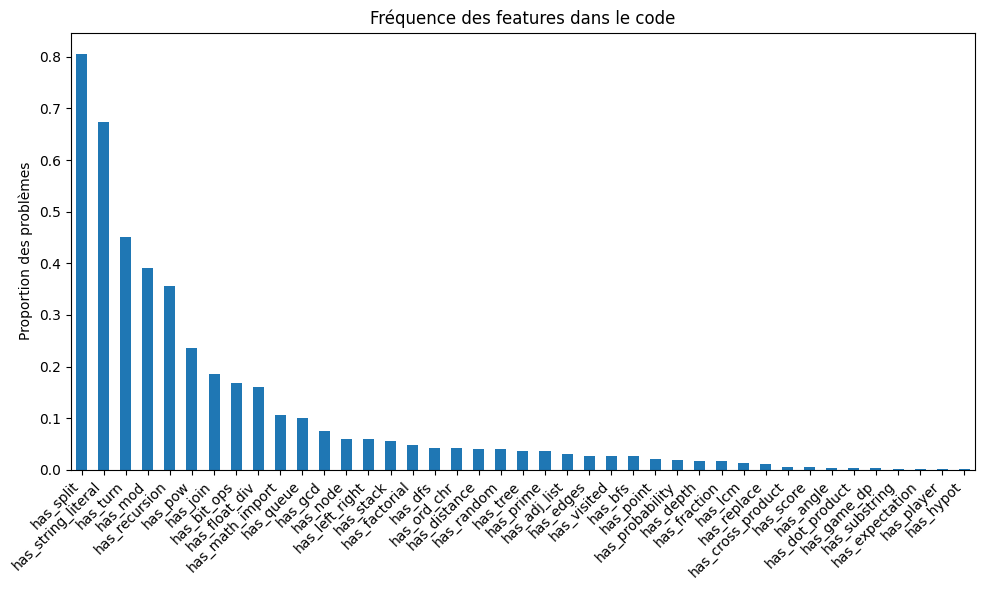

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
feature_freq.plot(kind="bar")
plt.title("Fréquence des features dans le code")
plt.ylabel("Proportion des problèmes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [68]:
math_corr = {}

for feat in feature_names:
    math_corr[feat] = df_full[df_full["games"] == 1][feat].mean()

pd.Series(math_corr).sort_values(ascending=False)


has_split             0.771429
has_string_literal    0.771429
has_mod               0.523810
has_turn              0.342857
has_bit_ops           0.304762
has_recursion         0.295238
has_pow               0.190476
has_join              0.133333
has_float_div         0.114286
has_queue             0.104762
has_gcd               0.057143
has_ord_chr           0.047619
has_node              0.047619
has_math_import       0.038095
has_random            0.028571
has_tree              0.028571
has_factorial         0.028571
has_left_right        0.028571
has_point             0.019048
has_prime             0.019048
has_dfs               0.019048
has_edges             0.019048
has_depth             0.019048
has_stack             0.019048
has_fraction          0.019048
has_probability       0.019048
has_visited           0.009524
has_angle             0.009524
has_player            0.009524
has_lcm               0.000000
has_replace           0.000000
has_bfs               0.000000
has_adj_list          0.000000
has_substring         0.000000
has_expectation       0.000000
has_game_dp           0.000000
has_score             0.000000
has_distance          0.000000
has_cross_product     0.000000
has_dot_product       0.000000
has_hypot             0.000000
dtype: float64

In [45]:
### Corrélation features code ↔ tags

### Corrélation features code ↔ tags

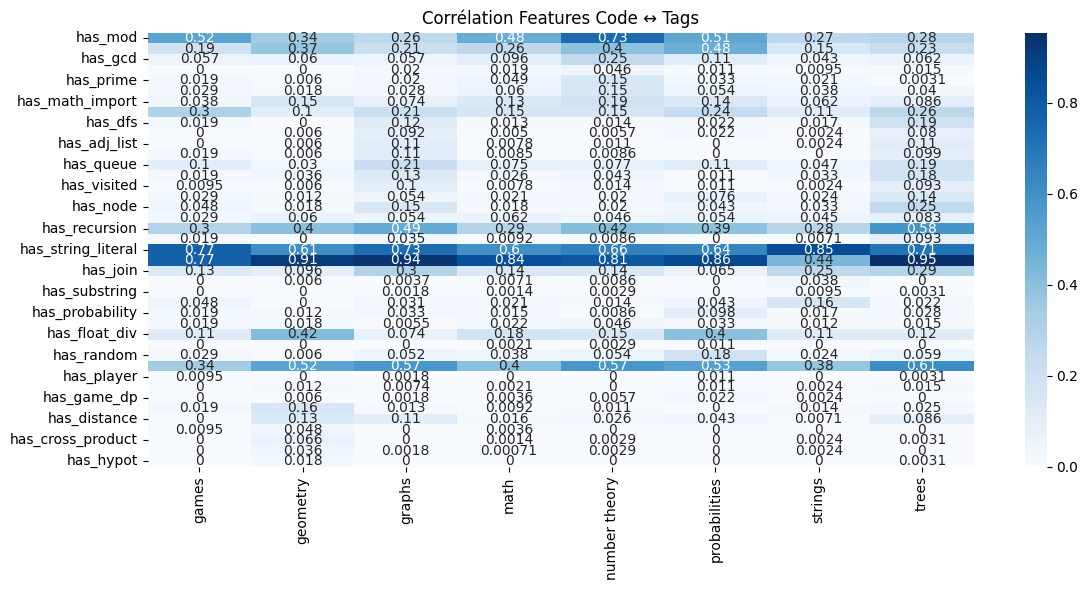

In [69]:
import seaborn as sns

tag_feature_corr = {}

for tag in mlb.classes_:
    tag_feature_corr[tag] = df_full[df_full[tag] == 1][feature_names].mean()

df_corr = pd.DataFrame(tag_feature_corr)

plt.figure(figsize=(12,6))
sns.heatmap(df_corr, annot=True, cmap="Blues")
plt.title("Corrélation Features Code ↔ Tags")
plt.tight_layout()
plt.show()
